# Preprocessing
## This notebook will focus on preparation of the dataset for training. The content of this notebook is as follows:
* We will begin with loading images and plotting graph to view image size distribution,
* Then image tagging will be performed and discussed,
* After generation of tags is finished a data split will be done to separate training data from images that will be used to test the model,
* With our newly created sets we will generate TF record files that will be used for training.

In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from IPython.display import Image

### Get home directory. 
### Do not run this again if you run any of the "cd" commands later in the notebook because you will overwrite your home directory path

In [2]:
cur_dir = os.getcwd()

### Get paths for directories that will be used further in the code

In [3]:
main_dir = os.path.dirname(cur_dir)
figures_dir = os.path.join(main_dir, "figures")
scripts_dir = os.path.join(main_dir, "scripts")
work_dir = os.path.join(main_dir, "public/Birds")
detect_dir = os.path.join(work_dir, "label", "detection")
data_dir = os.path.join(work_dir, "dataset")

### Load dimensions of images for analysis

In [4]:
data = []

for filename in os.listdir(data_dir):
    name, ext = os.path.splitext(filename)
    try:
        img = imread(os.path.join(data_dir, filename))
        height, width, color = img.shape
        t = ""
        if "Erithacus" in filename:
            t = "Erithacus_Rubecula"
        elif "Periparus" in filename:
            t = "Periparus_ater"
        elif "Pica" in filename:
            t = "Pica_pica"
        else:
            t = "Turdus_merula"
        data.append([height, width, t])      
    except:
        continue

### Plot images dimensions to see size distribution of images in dataset
##### As we can see on the graph majority of the pictures have width values in between 950 and 1024 pixels. Height on the other hand has two major groups: 600 to 800 pixels and 950 to 1024 pixels. This observation can help determine resize values to standardize images without distorting them. 

In [5]:
df = pd.DataFrame(data=data, columns=["height", "width", "species"])

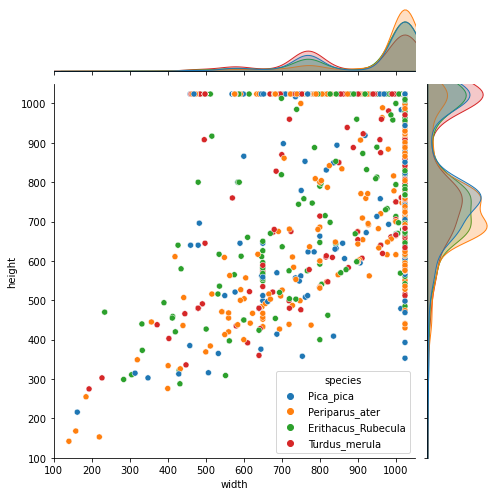

In [6]:
plot = sns.jointplot(data=df, x="width", y="height", hue="species", xlim=(100, 1050), ylim=(100, 1050), height=7)
plot.ax_joint.set_xticks([i for i in range(100, 1100, 100)])
plot.ax_joint.set_yticks([i for i in range(100, 1100, 100)]);

### More information about pictures
##### We can see substantial difference between minimum and maximum resolution values. Images cannot be resized to either of those values as many pictures would become very distorted. Finding optimal values (between min and max) for image resizing will be crucial for training.

In [7]:
df1 = pd.DataFrame(data={"Min": {"Height": np.min(df.height), "Width": np.min(df.width)},
                       "Max": {"Height": np.max(df.height), "Width": np.max(df.width)},
                       "Mean": {"Height": round(np.mean(df.height), 2), "Width": round(np.mean(df.width), 2)}
                       },
                 )
df1

,Min,Max,Mean
Height,142,1024,803.42
Width,140,1024,927.22


### Prepare list of labels for tagging

In [8]:
!gedit $work_dir/label_candidates.json

### Below a screenshot of prepared class labels for birds dataset

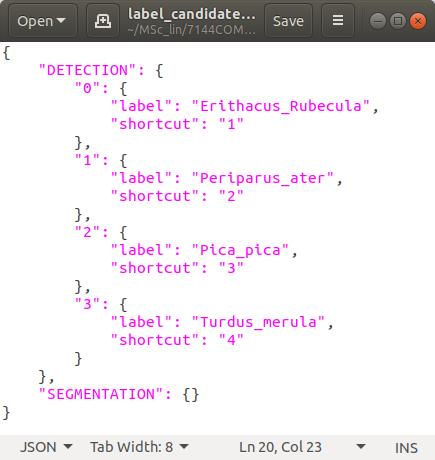

In [9]:
Image(filename = f"{figures_dir}/tagging_labels.png", width = 400)

### This dataset has a minor issue regarding its filenames which makes 3000 images not being loaded by tagging application because of whitespaces in filenames.
### Below code will standardize filenames by removing all whitespaces

In [10]:
for filename in os.listdir(data_dir):
    if " " in filename:
        os.rename(os.path.join(data_dir, filename), os.path.join(data_dir, filename.replace(" ", "")))

### Now lets start ReNomTAG and generate tags for all images.
##### ReNomTag produces XML files which contain information about created bounding boxes for each image.
##### Pascal VOC format is used for this project.

In [11]:
%cd $main_dir
!python -m renom_tag

/home/michal/MSc_lin/7144COMP/Coursework_2
Bottle v0.12.18 server starting up (using WSGIRefServer())...
Listening on http://0.0.0.0:8885/
Hit Ctrl-C to quit.

^C


### With all of the tagging finished it is now time to convert generated XML files as model will not read them in the current format.
##### For each file we have to remove every whitespace and new lines. The conversion will result in reduction of the content to a single string value.
##### Moreover, the script will create a new folder "cleaned" and place inside newly converted xml files together with their images.
##### xmlconversion.py script will be used to perform the cleaning. Please provide all input and output paths.

In [12]:
%cd $scripts_dir
!python xmlconversion.py -i $data_dir -x $detect_dir -o $work_dir

/home/michal/MSc_lin/7144COMP/Coursework_2/scripts


In [13]:
cleaned_dir = os.path.join(work_dir, "cleaned")

### Next step is to split the data into train and test sets.
##### To do this we will use another script. Please make sure to provide input and output (parent) paths as there are no default values for them.

In [14]:
!python partition_dataset.py -x -i $cleaned_dir -o $work_dir -r 0.1

### Now we have to create a label map for a model with all classes previously defined as label candidates
##### We have to make sure that all labels are included

In [15]:
%cd $work_dir
!gedit 'label_map.pbtxt'

/home/michal/MSc_lin/7144COMP/Coursework_2/public/Birds


### Now it is time to generate TFRecords for train and test sets

In [16]:
%cd $scripts_dir
!python generate_tfrecord.py -x $work_dir/train -l $work_dir/label_map.pbtxt -o $work_dir/train.record
!python generate_tfrecord.py -x $work_dir/test -l $work_dir/label_map.pbtxt -o $work_dir/test.record

/home/michal/MSc_lin/7144COMP/Coursework_2/scripts
Successfully created the TFRecord file: /home/michal/MSc_lin/7144COMP/Coursework_2/public/Birds/train.record
Successfully created the TFRecord file: /home/michal/MSc_lin/7144COMP/Coursework_2/public/Birds/test.record
